## Подготовка данных

In [1]:
import datetime
import os
import geopandas as gpd
import pandas as pd
import numpy as np
import math
pd.options.display.max_columns = 999
local_crs = 4326
example_data_path = "./VRP/exp_data/"
matrix_data_path = "./VRP/exp_data/access_matrix_48"

In [2]:
blocks = gpd.read_parquet(os.path.join(example_data_path, "blocks_cutter_result.parquet")).to_crs(local_crs)
polygon = gpd.read_parquet(os.path.join(example_data_path, "blocks_cutter_result.parquet")).to_crs(local_crs)
accessibility_matrix = pd.read_pickle(os.path.join(matrix_data_path, "matrix_mon_0900.pickle"))
demands = pd.read_csv(os.path.join(example_data_path, "second_scenario.csv"))
demands.rename(columns={'Unnamed: 0': 'date'}, inplace=True)
demands['date'] = pd.to_datetime(demands['date'])
# Устанавливаем 'date' в качестве индекса
demands.set_index('date', inplace=True)

In [3]:
blocks['centroid'] = blocks['geometry'].centroid
blocks.geometry = blocks['centroid']
# blocks.geometry = blocks['geometry'].centroid
blocks.drop(columns=['centroid', 'landuse'], inplace=True)
# Получение 40 случайных строк из исходного GeoDataFrame
blocks_40 = blocks.sample(n=41, random_state=1)  # Используйте другой random_state для другой выборки
# Создание нового GeoDataFrame на основе случайных строк
blocks_40 = gpd.GeoDataFrame(blocks_40, geometry='geometry', crs=blocks_40.crs)
blocks_40.reset_index(drop=True, inplace=True)
blocks_40['vrp_id'] = blocks_40.index
blocks_40.head()

/var/folders/h8/0wmx2zx90bn60jw8zc1r4qjc0000gn/T/ipykernel_2539/1994219230.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  blocks['centroid'] = blocks['geometry'].centroid


,geometry,id,vrp_id
0,POINT (30.23725 59.94681),91,0
1,POINT (30.23616 59.93375),443,1
2,POINT (30.27768 59.94933),776,2
3,POINT (30.23291 59.95444),482,3
4,POINT (30.27220 59.93560),1073,4


In [4]:
# Функция для извлечения координат из геометрии
def extract_coordinates(row):
    return row['geometry'].x, row['geometry'].y

# Применение функции к каждой строке GeoDataFrame
blocks_40['coordinates'] = blocks_40.apply(extract_coordinates, axis=1)

# Преобразование координат в массив numpy
coordinates_array = np.array(blocks_40['coordinates'].tolist())

coordinates_array

array([[30.23725223, 59.94681097],
       [30.23615802, 59.93375286],
       [30.277682  , 59.94933284],
       [30.23291334, 59.95444208],
       [30.27220029, 59.9355989 ],
       [30.2920856 , 59.94028113],
       [30.24740838, 59.95465574],
       [30.2465466 , 59.94967585],
       [30.27443905, 59.93945694],
       [30.28112209, 59.94055325],
       [30.26709624, 59.93848723],
       [30.26132438, 59.93312537],
       [30.2253302 , 59.9326824 ],
       [30.20965571, 59.95089336],
       [30.24014745, 59.95016267],
       [30.27370056, 59.93642756],
       [30.23820194, 59.93056522],
       [30.22145889, 59.93357544],
       [30.26736085, 59.95338766],
       [30.28285029, 59.9481095 ],
       [30.2742119 , 59.93677489],
       [30.24658721, 59.93650089],
       [30.27102015, 59.93064191],
       [30.2679881 , 59.93489392],
       [30.25979894, 59.94808359],
       [30.23831776, 59.94709691],
       [30.26626537, 59.94770951],
       [30.22902667, 59.9585606 ],
       [30.22322408,

In [5]:
def get_matrix(timestamp):
    hour = timestamp.hour
    filename = f"matrix_mon_{hour:02d}00.pickle"
    file_path = os.path.join(matrix_data_path, filename)
    accessibility_matrix = pd.read_pickle(file_path)
    # Получение списка id кварталов из GeoDataFrame
    quarters_ids = blocks_40['id'].tolist()

    # Фильтрация матрицы связанности по кварталам из GeoDataFrame
    filtered_matrix_df = accessibility_matrix.loc[quarters_ids, quarters_ids]

    array_matrix = filtered_matrix_df.values#.astype(int)
    return array_matrix*2

Период неделя
Цикл начинает из каждого склада для пиццерии вычитать спрос за час
так же задать другую переменную (20 % от 1000), которая задаёт объём склада и минимум, когда срабатывает условие начала доставки 
объём доставки - это пополнить склад пиццерий полностью

40 точек закидываются в случайные кварталы на Ваське

Попробовать среднюю оценку по всем пиццериям (по всем

передавать в ортулс точки и сколько груза отвезти

In [6]:
def get_orders_by_date(number_orders, GNN):
    if GNN == True:
        try:
            demand = np.array(number_orders)
            # demand[0] = 0
            demand = np.insert(demand, 0, 0)
            demand = demand/1000
            float_array = demand.astype(float)
            float_array = np.round(float_array, 3)
            return float_array
        except KeyError:
            return np.array([])  # Если дата не найдена, возвращаем пустой список
    else:
        try:
            number_orders[0] = 0
            return number_orders
        except KeyError:
            return []  # Если дата не найдена, возвращаем пустой список

## GNN

In [7]:
import torch
import os
import numpy as np
from torch_geometric.data import Data, DataLoader
# from VRP.creat_vrp import reward1,creat_instance
from VRP.VRP_Actor import Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from matplotlib import pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

/Users/mvin/Code/DRL-and-graph-neural-network-for-routing-problems/vrptest/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
if torch.cuda.is_available():
    print("CUDA доступен")
    print("Устройство:", torch.cuda.get_device_name(0))
else:
    print("CUDA не доступен, используется CPU")

CUDA не доступен, используется CPU


In [9]:
def GNN_method(number_orders, lifting_capacity, array_matrix, unloading_time):

    def cal_cost(routes):
        # Вычисление длины каждого маршрута
        route_time = []
        total_length = 0.0
        for route in routes:
            route_length = sum(array_matrix[route[i]][route[i + 1]] for i in range(len(route) - 1))
            route_length += array_matrix[0][route[0]]
            route_length += array_matrix[route[-1]][0]
            total_length += route_length
            route_time.append(route_length)
        return total_length, route_time

    n_nodes = 41
    actor = 21
    x=0 # выбираем набор данных

    node_ = coordinates_array
    demand_ = get_orders_by_date(number_orders, GNN = True)
    capcity_ = np.array([lifting_capacity / 1000], dtype=float)
    # capcity_ = np.array([8.0]) #настройка вместимости транспорта

    # node_ = node_.reshape(-1, n_nodes, 2)
    node_,demand_=node_.reshape(-1,n_nodes,2),demand_.reshape(-1,n_nodes)

    # data_size = node_.shape[0]
    np_matrix = array_matrix.astype(int)
    np_matrix = np_matrix.reshape(-1, 1)

    # edges = np.zeros((n_nodes, n_nodes, 1))
    # def c_dist(x1, x2):
    #     # return ((x1[0] - x2[0]) ** 2 + (x1[1] - x2[1]) ** 2) ** 0.5
    #     return ((x1[0] - x2[0]) ** 2 + (x1[1] - x2[1]) ** 2) ** 0.5
    # for i, (x1, y1) in enumerate(node_[x]):
    #     for j, (x2, y2) in enumerate(node_[x]):
    #         d = c_dist((x1, y1), (x2, y2))
    #         edges[i][j][0] = d
    # edges_ = edges.reshape(-1, 1)

    edges_index = []
    for i in range(n_nodes):
        for j in range(n_nodes):
            edges_index.append([i, j])
    edges_index = torch.LongTensor(edges_index)
    edges_index = edges_index.transpose(dim0=0, dim1=1)

    agent = Model(3, 128, 1, 16, conv_laysers=4).to(device)
    agent.to(device)
    folder = 'trained'
    filepath = os.path.join(folder, '%s' % actor)
    if os.path.exists(filepath):
            path1 = os.path.join(filepath, 'actor.pt')
            agent.load_state_dict(torch.load(path1, device))

    datas_ = []
    batch_size1 = 1 # sampling batch_size
    for y in range(10):
        data = Data(x=torch.from_numpy(node_[x]).float(), 
                    edge_index=edges_index,
                    edge_attr=torch.from_numpy(np_matrix).float(),
                    demand=torch.tensor(demand_[x]).unsqueeze(-1).float(),
                    capcity=torch.tensor(capcity_[0]).unsqueeze(-1).float())
        datas_.append(data)
    dl = DataLoader(datas_, batch_size=batch_size1)

    min_tour=[]
    min_cost=1000
    T=1.8 #Temperature hyperparameters

    for batch in dl:
        costs = []
        with torch.no_grad():
            batch.to(device)
            tour1, _ = agent(batch, n_nodes * 2, False, T)
            for tour in tour1:
                routes_1 = [r[r != 0] for r in np.split(tour.cpu().numpy(), np.where(tour.cpu().numpy() == 0)[0]) if (r != 0).any()]
                cost, route_t = cal_cost(routes_1)
                costs.append(cost)
            id = np.array(costs).argmin()
            m_cost=np.array(costs).min()
            if m_cost<min_cost:
                min_cost=m_cost
                min_tour=tour1[id]

    tour=min_tour.unsqueeze(-2)
    time = min_cost
    
    # print('Problem:VRP''%s' % n_nodes,'/ Average time:', time)
    for i, (data, tour) in enumerate(zip(dl, tour)):
        routes = [r[r != 0] for r in np.split(tour.cpu().numpy(), np.where(tour.cpu().numpy() == 0)[0]) if (r != 0).any()]
        cost, route_time = cal_cost(routes)
    print('_______________')
    # depot = data.x[0].cpu().numpy()
    locs = data.x[1:].cpu().numpy()
    demands = data.demand.cpu().numpy()
    demands=demands[1:]
    total = 0
    total_unloading_time = 0 
    for veh_number, r in enumerate(routes):
        unloading_t = len(r) * unloading_time
        total_unloading_time += unloading_t
        time_v = route_time[veh_number]
        route_demands = demands[r - 1]
        coords = locs[r - 1, :]
        xs, ys = coords.transpose()
        total_route_demand = sum(route_demands)
        total += total_route_demand*1000
        print(f'Маршрут {veh_number}, Груз на маршруте - {total_route_demand*1000}, Количество посещаемых узлов - {len(r)}, Время - {round(time_v+unloading_t, 2)}')
    time+=total_unloading_time
    rounded_time = round(time, 2)
    print(f'Итоговый груз {total}')
    print(f'Итоговое время {rounded_time}')    
    return(rounded_time, routes, route_time)

## Недельная модель падения спроса

In [10]:
import warnings

# Отключение предупреждений типа UserWarning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)


In [11]:
def total_cost(lifting_capacity, daily_car, daily_time):

    rental_prices = {'2000': 1000, '4000': 1500, '6000': 2000, '8000': 2500, '10000': 3000}
    price_per_minute = {'2000': 2, '4000': 3, '6000': 4, '8000': 5, '10000': 6}
    total = 0 
    Rcost = 0
    Dcost = 0
    lifting_capacity_str = str(lifting_capacity)
    
    for day, count in daily_car.items():
        Rcost += count * rental_prices[lifting_capacity_str]

    for day, count in daily_time.items():
        Dcost += count * price_per_minute[lifting_capacity_str]
        
    total = Rcost + Dcost
    print(f'Затраты на аренду автомобилей {Rcost}')
    print(f'Затраты на маршруты составляет {Dcost}')
    return total



In [12]:
warehouse_number = 500 # объем скалада
lifting_capacity = 4000 # грузополъемность одного автомобиля
unloading_time = 5  # Время разгрузки
first_date, last_date = '2023-07-01', '2023-07-07'
# vehicles_number = 9

warehouses = demands.copy()
warehouses = warehouses.loc[first_date:last_date]
warehouses[warehouses.columns] = 0
warehouses.loc[first_date + ' 00:00:00'] = warehouse_number

day_count = []
time_dict = [] # Время выездов 
time_dict_GNN = [] # Итогове время каждой развозки 
all_routes_GNN = [] # Все маршруты
orders_list = [] 
route_time_GNN = {}
daywise_count = {}

for time in warehouses.index:
    coef = []
    for i in range(len(warehouses.columns)): 
        if warehouses.loc[time, str(i)] == warehouse_number:
            continue
        else:
            warehouses.loc[time, str(i)] = warehouses.loc[time-datetime.timedelta(hours=1), str(i)] - demands.loc[time, str(i)]
            coef.append((warehouse_number - warehouses.loc[time, str(i)])/warehouse_number)
    if np.mean(coef)> 0.6 or any(element == True for element in [c > 0.8  for c in coef]) == True:
        orders = warehouse_number * np.asarray(coef)
        orders = orders.tolist()
        orders_list.append(orders)
        print(f'Время начала доставки - {time}')
        time_dict.append(time)
        # print('Решение нейронной сети')
        array_matrix = get_matrix(time)    
        # array_matrix = get_matrix(warehouses.index[9])  
        time_GNN, routes_GNN, cost_GNN = GNN_method(orders, lifting_capacity, array_matrix, unloading_time)
        route_time_GNN[time] = time_GNN
        daywise_count[time] = len(routes_GNN)
        time_dict_GNN.append(time_GNN)
        all_routes_GNN.append(routes_GNN)
        print('__________________________________')
        # print(f'Метод OR-Tools для {vehicles_number} машин грузоподъёмностью {lifting_capacity}')
        # OR_Tools_method(orders, vehicles_number , lifting_capacity)
        warehouses.loc[time+datetime.timedelta(hours=1)] = warehouse_number
# warehouses           
sum_time_GNN = sum(time_dict_GNN)

# Групировка машин по дням
daily_car = {}
for timestamp, cars_count in daywise_count.items():
    day = timestamp.date()  # Получаем день из метки времени
    if day in daily_car:
        daily_car[day] = max(daily_car[day], cars_count)
    else:
        daily_car[day] = cars_count
    
# Групировка времени в пути по дням
daily_time = {}
for timestamp, minutes in route_time_GNN.items():
    day = timestamp.date()  # Получаем день из метки времени
    if day in daily_time:
        daily_time[day] += minutes
    else:
        daily_time[day] = minutes
print('____')
print(sum_time_GNN)

Время начала доставки - 2023-07-01 15:00:00
_______________
Маршрут 0, Груз на маршруте - [3931.], Количество посещаемых узлов - 14, Время - 192.6
Маршрут 1, Груз на маршруте - [3987.9998], Количество посещаемых узлов - 14, Время - 244.0
Маршрут 2, Груз на маршруте - [3686.9998], Количество посещаемых узлов - 12, Время - 176.8
Итоговый груз [11606.]
Итоговое время 613.4
__________________________________
Время начала доставки - 2023-07-01 21:00:00
_______________
Маршрут 0, Груз на маршруте - [1487.], Количество посещаемых узлов - 5, Время - 77.8
Маршрут 1, Груз на маршруте - [3882.], Количество посещаемых узлов - 14, Время - 194.6
Маршрут 2, Груз на маршруте - [3950.], Количество посещаемых узлов - 13, Время - 169.0
Маршрут 3, Груз на маршруте - [1660.], Количество посещаемых узлов - 6, Время - 85.8
Маршрут 4, Груз на маршруте - [334.], Количество посещаемых узлов - 1, Время - 18.0
Маршрут 5, Груз на маршруте - [203.], Количество посещаемых узлов - 1, Время - 17.8
Итоговый груз [11516

In [13]:
sklad = [500, 900, 1500, 2000]
avto = [2000, 4000, 6000, 8000]
cost=[]
vremya = []
for s in sklad:
    for a in avto:
        warehouse_number = s # объем скалада
        lifting_capacity = a # грузополъемность одного автомобиля
        unloading_time = 5  # Время разгрузки
        first_date, last_date = '2023-07-01', '2023-07-07'
        # vehicles_number = 9

        warehouses = demands.copy()
        warehouses = warehouses.loc[first_date:last_date]
        warehouses[warehouses.columns] = 0
        warehouses.loc[first_date + ' 00:00:00'] = warehouse_number

        day_count = []
        time_dict = [] # Время выездов 
        time_dict_GNN = [] # Итогове время каждой развозки 
        all_routes_GNN = [] # Все маршруты
        orders_list = [] 
        route_time_GNN = {}
        daywise_count = {}

        for time in warehouses.index:
            coef = []
            for i in range(len(warehouses.columns)): 
                if warehouses.loc[time, str(i)] == warehouse_number:
                    continue
                else:
                    warehouses.loc[time, str(i)] = warehouses.loc[time-datetime.timedelta(hours=1), str(i)] - demands.loc[time, str(i)]
                    coef.append((warehouse_number - warehouses.loc[time, str(i)])/warehouse_number)
            if np.mean(coef)> 0.6 or any(element == True for element in [c > 0.8  for c in coef]) == True:
                orders = warehouse_number * np.asarray(coef)
                orders = orders.tolist()
                orders_list.append(orders)
                print(f'Время начала доставки - {time}')
                time_dict.append(time)
                # print('Решение нейронной сети')
                array_matrix = get_matrix(time)    
                # array_matrix = get_matrix(warehouses.index[9])  
                time_GNN, routes_GNN, cost_GNN = GNN_method(orders, lifting_capacity, array_matrix, unloading_time)
                route_time_GNN[time] = time_GNN
                daywise_count[time] = len(routes_GNN)
                time_dict_GNN.append(time_GNN)
                all_routes_GNN.append(routes_GNN)
                print('__________________________________')
                # print(f'Метод OR-Tools для {vehicles_number} машин грузоподъёмностью {lifting_capacity}')
                # OR_Tools_method(orders, vehicles_number , lifting_capacity)
                warehouses.loc[time+datetime.timedelta(hours=1)] = warehouse_number
        # warehouses           
        sum_time_GNN = sum(time_dict_GNN)

        # Групировка машин по дням
        daily_car = {}
        for timestamp, cars_count in daywise_count.items():
            day = timestamp.date()  # Получаем день из метки времени
            if day in daily_car:
                daily_car[day] = max(daily_car[day], cars_count)
            else:
                daily_car[day] = cars_count
            
        # Групировка времени в пути по дням
        daily_time = {}
        for timestamp, minutes in route_time_GNN.items():
            day = timestamp.date()  # Получаем день из метки времени
            if day in daily_time:
                daily_time[day] += minutes
            else:
                daily_time[day] = minutes
        print('____')
        print(sum_time_GNN)
        totall = total_cost(lifting_capacity, daily_car, daily_time)
        cost.append(totall)
        vremya.append(sum_time_GNN)


Время начала доставки - 2023-07-01 15:00:00
_______________
Маршрут 0, Груз на маршруте - [1802.], Количество посещаемых узлов - 6, Время - 106.2
Маршрут 1, Груз на маршруте - [1854.9999], Количество посещаемых узлов - 6, Время - 88.8
Маршрут 2, Груз на маршруте - [1979.0001], Количество посещаемых узлов - 9, Время - 121.2
Маршрут 3, Груз на маршруте - [1742.9999], Количество посещаемых узлов - 5, Время - 72.4
Маршрут 4, Груз на маршруте - [1877.], Количество посещаемых узлов - 6, Время - 96.2
Маршрут 5, Груз на маршруте - [1270.9999], Количество посещаемых узлов - 4, Время - 61.6
Маршрут 6, Груз на маршруте - [835.], Количество посещаемых узлов - 3, Время - 64.8
Маршрут 7, Груз на маршруте - [244.], Количество посещаемых узлов - 1, Время - 28.0
Итоговый груз [11606.]
Итоговое время 639.2
__________________________________
Время начала доставки - 2023-07-01 21:00:00
_______________
Маршрут 0, Груз на маршруте - [1846.], Количество посещаемых узлов - 6, Время - 85.0
Маршрут 1, Груз на м

In [14]:
cost 

[80528.8,
 78525.0,
 90498.4,
 117620.0,
 77782.8,
 96684.0,
 92405.6,
 76999.0,
 64870.8,
 52588.2,
 53817.6,
 62459.0,
 59893.6,
 46561.8,
 47713.6,
 49505.0]

In [15]:
vremya

[7764.400000000001,
 7175.0,
 7124.6,
 7024.0,
 4391.400000000001,
 4227.999999999999,
 4101.4,
 3899.7999999999997,
 2435.4,
 2029.4,
 1954.4,
 1991.8000000000002,
 1946.8,
 1520.6,
 1428.4,
 1401.0]

In [16]:
totall = total_cost(lifting_capacity, daily_car, daily_time)
print(f'Итоговая стоимость за период с {first_date} по {last_date} составляет {totall}')


Затраты на аренду автомобилей 42500
Затраты на маршруты составляет 7005.0
Итоговая стоимость за период с 2023-07-01 по 2023-07-07 составляет 49505.0


In [17]:
# Подсчет времени, затраченного каждой машиной на разгрузку
total_unloading_time = 0 
count = 0 
for r in all_routes_GNN:
    print(f'Выезд {time_dict[count]}')
    count +=1
    for car_id, visits in enumerate(r):
        unloading_t = len(visits) * unloading_time
        print(f"Машина {car_id} потратила {unloading_t} минут на разгрузку товара.")
        total_unloading_time +=unloading_t
total_unloading_time


Выезд 2023-07-02 17:00:00
Машина 0 потратила 40 минут на разгрузку товара.
Машина 1 потратила 40 минут на разгрузку товара.
Машина 2 потратила 30 минут на разгрузку товара.
Машина 3 потратила 30 минут на разгрузку товара.
Машина 4 потратила 10 минут на разгрузку товара.
Машина 5 потратила 30 минут на разгрузку товара.
Машина 6 потратила 10 минут на разгрузку товара.
Машина 7 потратила 10 минут на разгрузку товара.
Выезд 2023-07-05 16:00:00
Машина 0 потратила 35 минут на разгрузку товара.
Машина 1 потратила 20 минут на разгрузку товара.
Машина 2 потратила 45 минут на разгрузку товара.
Машина 3 потратила 30 минут на разгрузку товара.
Машина 4 потратила 40 минут на разгрузку товара.
Машина 5 потратила 5 минут на разгрузку товара.
Машина 6 потратила 15 минут на разгрузку товара.
Машина 7 потратила 5 минут на разгрузку товара.
Машина 8 потратила 5 минут на разгрузку товара.


400

In [18]:
daywise_count

{Timestamp('2023-07-02 17:00:00'): 8, Timestamp('2023-07-05 16:00:00'): 9}

In [19]:
daily_car

{datetime.date(2023, 7, 2): 8, datetime.date(2023, 7, 5): 9}

In [20]:
average_value = sum(daily_car.values()) / len(daily_car)

print("Среднее значение:", average_value)

Среднее значение: 8.5


In [21]:
route_time_GNN

{Timestamp('2023-07-02 17:00:00'): 732.6,
 Timestamp('2023-07-05 16:00:00'): 668.4}

In [22]:
daily_time

{datetime.date(2023, 7, 2): 732.6, datetime.date(2023, 7, 5): 668.4}

In [23]:
average_value = sum(daily_time.values()) / len(daily_time)

print("Среднее значение:", average_value)

Среднее значение: 700.5


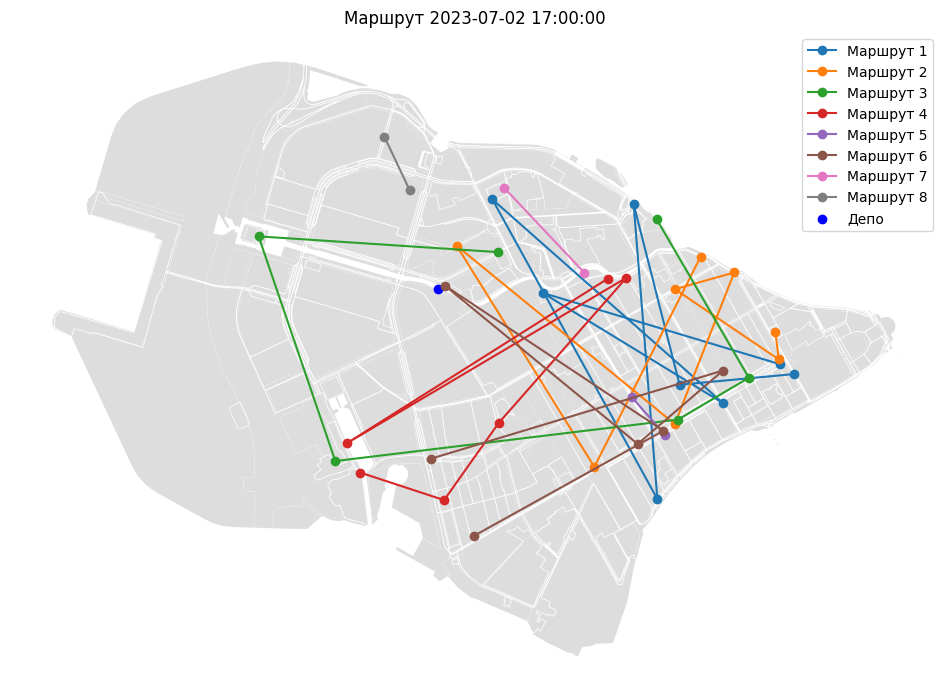

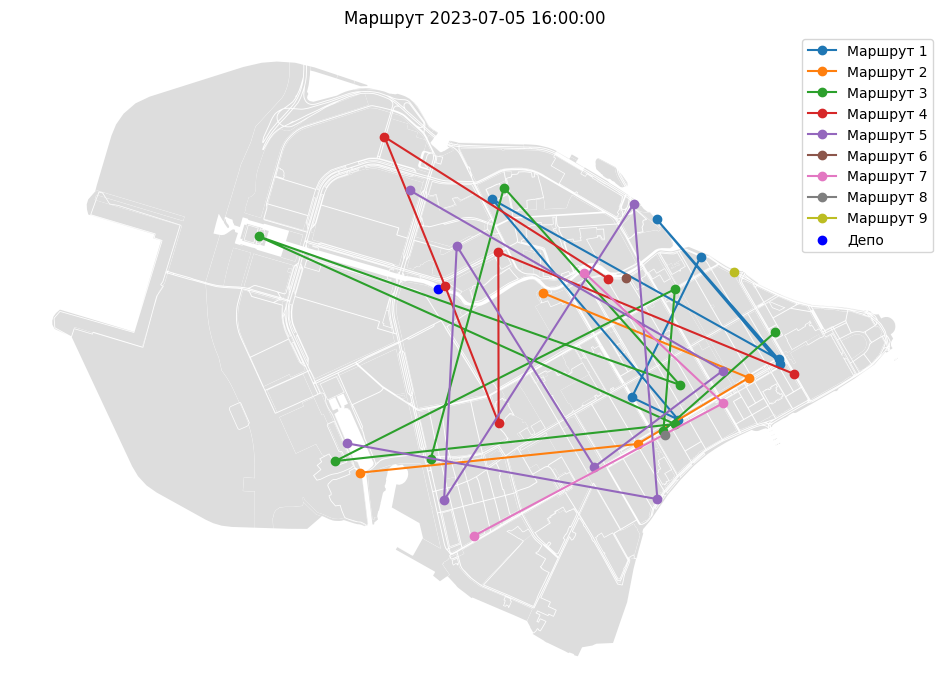

In [24]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

# Предположим, что у вас есть массив маршрутов routes
routes = all_routes_GNN

df_points = blocks_40  # ваш DataFrame с точками 
# Проход по каждому элементу в массиве маршрутов
for idx, route_points in enumerate(routes):
    # Визуализация точек и маршрутов для текущего маршрута
    plt.figure(figsize=(12, 12))  # Здесь 10 - ширина, 8 - высота
    r = 0 
    for sub_route in route_points:
        r +=1
        sub_route_points = df_points[df_points['vrp_id'].isin(sub_route)]
        plt.plot(sub_route_points['geometry'].x, sub_route_points['geometry'].y, label=f'Маршрут {r}', marker='o')
    
    # Добавление легенды и названий осей
    polygon.plot(ax=plt.gca(), color="#ddd", alpha=1)
    plt.scatter(df_points.iloc[0]['geometry'].x, df_points.iloc[0]['geometry'].y, label='Депо', color='blue')
    plt.legend()
    plt.gca().set_axis_off()
    plt.title(f'Маршрут {time_dict[idx]}')
    # plt.title(f'Визуализация маршрутов {idx+1}')
    # Отображение графика
    plt.show()


In [25]:
# Создаем список чисел
numbers = [9.47, 9.904, 3.127, 6.893, 7.131, 6.212, 8.675, 6.1, 7.32, -1.48, 3.16, 8.35, 7.24, 5.134, 9.043, 5.186]

# Суммируем числа
sum_of_numbers = sum(numbers)

# Вычисляем количество чисел
count_of_numbers = len(numbers)

# Вычисляем среднее значение
average = sum_of_numbers / count_of_numbers

print("Сумма чисел:", sum_of_numbers)
print("Количество чисел:", count_of_numbers)
print("Среднее значение:", average)

Сумма чисел: 101.465
Количество чисел: 16
Среднее значение: 6.3415625


### Маршруты

In [26]:
import geopandas as gpd
from shapely import LineString, Point, MultiLineString, line_merge
blocks_paths = gpd.read_parquet('blocks_paths.parquet')
blocks = gpd.read_parquet(os.path.join(example_data_path, "blocks_cutter_result.parquet"))

In [27]:
def path_to_linestring(path):
    lines = []
    for u, v in zip(path[:-1], path[1:]):
        geom = blocks_paths.loc[u, v].geometry
        if isinstance(geom, LineString):
            lines.append(geom)

        elif isinstance(geom, MultiLineString):
            lines.append(geom)

    return MultiLineString(lines)

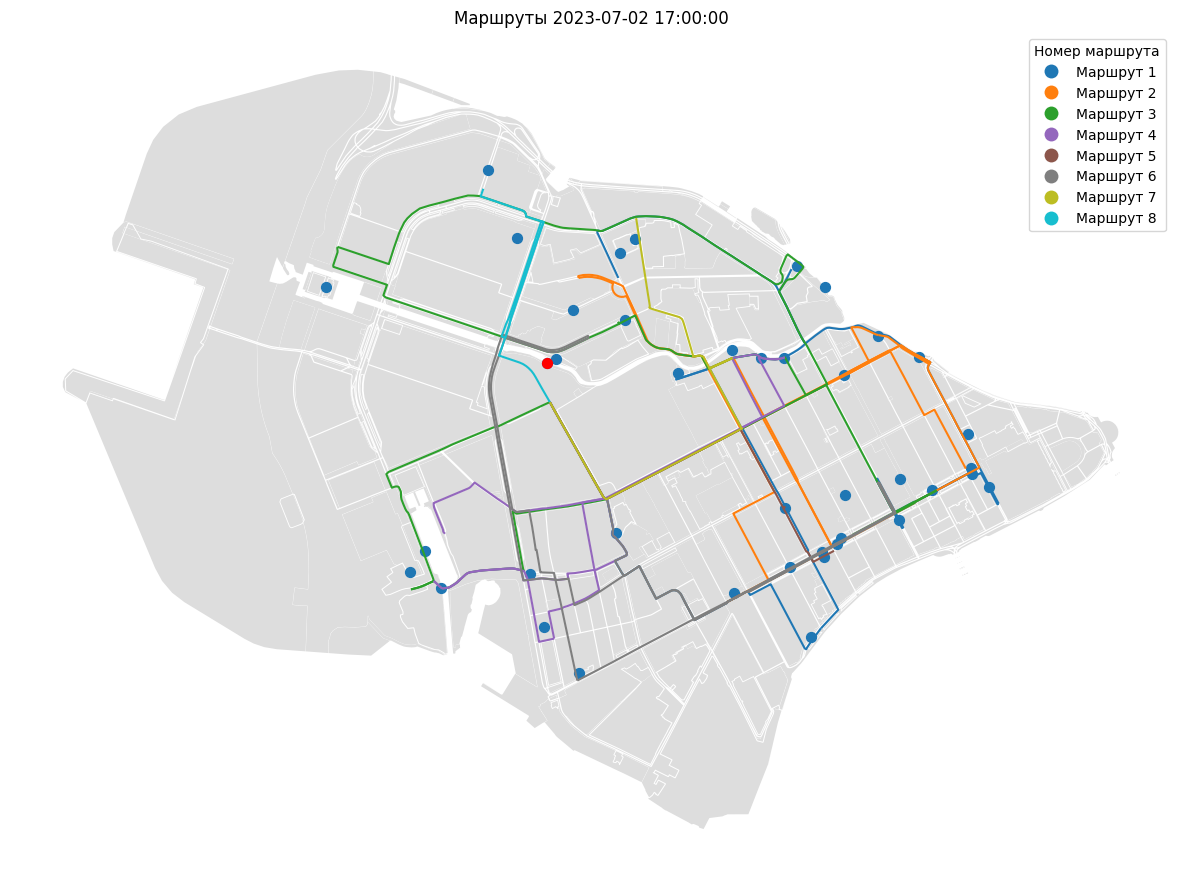

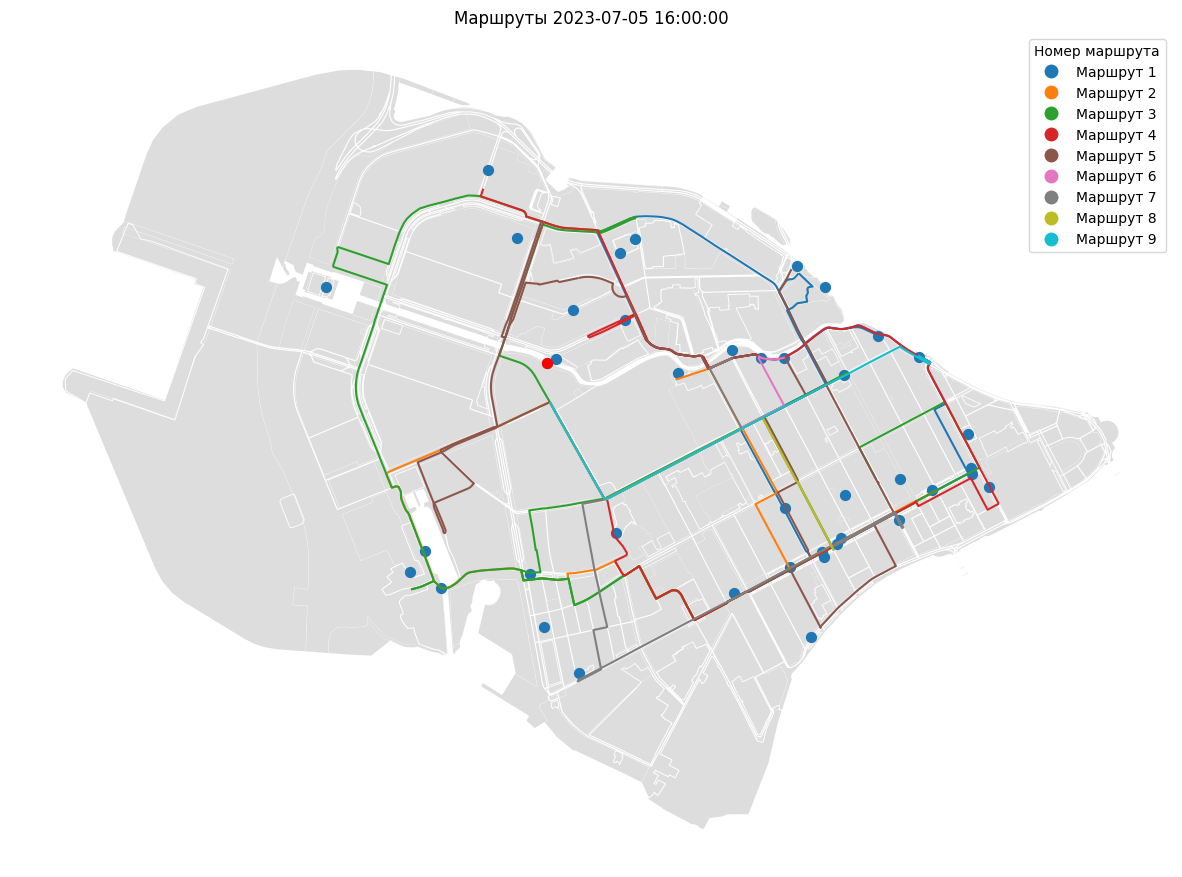

In [28]:
df_points = blocks_40  # ваш DataFrame с точками 
df_points = df_points.to_crs(32636)
routes = all_routes_GNN

for idx, route in enumerate(routes):
    paths = [arr.tolist() for arr in route]
    for path in paths:
        path.insert(0, 0)
    paths_gdf = gpd.GeoDataFrame([path_to_linestring(path) for path in paths], columns=['geometry'], geometry='geometry', crs=blocks.crs)
    # paths_gdf['path'] = paths_gdf.index.astype(str)
    paths_gdf['path'] = ['Маршрут ' + str(i) for i in range(1, len(paths_gdf) + 1)]
    ax = blocks.plot(color='#ddd', figsize=[15,15])
    paths_gdf.plot(column='path', ax=ax, legend=True, legend_kwds={'title': 'Номер маршрута'})
    df_points.plot(ax=ax, marker='o', markersize=50) 
    filter_values = df_points.iloc[0].values
    # Используйте фильтр для выбора соответствующих строк и выполнения операции plot
    df_points[df_points.eq(filter_values).all(axis=1)].plot(ax=ax, marker='o', markersize=50, color='red')
     # Используйте нужные вам параметры для визуализации точек
    plt.title(f'Маршруты {time_dict[idx]}')
    ax.set_axis_off()
    plt.show()